# Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

# Load the dataset

In [2]:
# EMNIST ByClass:   814,255 characters. 62 unbalanced classes.
train_set = datasets.EMNIST(
                            root='./data'
                            ,split="byclass"          
                            ,train=True
                            ,download=True
                            ,transform=transforms.Compose([
                                transforms.RandomHorizontalFlip()
                                ,transforms.ToTensor()
                                ])
                            )

In [3]:
test_set = datasets.EMNIST(
                            root='./data'
                            ,split="byclass"
                            ,train=False
                            ,download=True
                            ,transform=transforms.Compose([
                                transforms.ToTensor()
                                ])
                            )

In [5]:
len(train_set.classes)

62

# DataLoader (For `train` and `test`)

In [6]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments 
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train_set, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test_set, **dataloader_args)

CUDA Available? True


In [7]:
train_set.data.shape

torch.Size([697932, 28, 28])

[Train]
 - Numpy Shape: (697932, 28, 28)
 - Tensor Shape: torch.Size([697932, 28, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1736)
 - std: tensor(0.3317)
 - var: tensor(0.1100)
torch.Size([128, 1, 28, 28])
torch.Size([128])


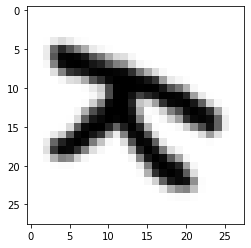

In [8]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already

train_data = train_set.data
train_data = train_set.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train_set.data.cpu().numpy().shape)
print(' - Tensor Shape:', train_set.data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

In [9]:
print(f"Label is {labels[0]}")

Label is 46


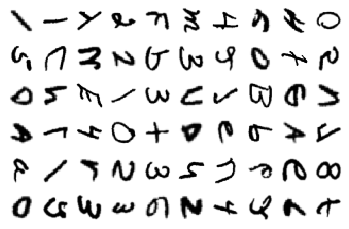

In [10]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# Model

In [16]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 26 x 26 

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 24 x 24 

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 12 x 12 

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 10 x 10
        
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=30, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 8 x 8

        # OUTPUT BLOCK
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=30, out_channels=62, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 8 x 8 
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=8)
        ) # output_size = 1

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.pool1(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.gap(x)
        x = x.view(-1, 62)
        return F.log_softmax(x, dim=-1)

# Model Params

In [17]:
#!pip install torchsummary

In [18]:
from torchsummary import summary

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

print(device)

model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
            Conv2d-3           [-1, 10, 24, 24]             900
              ReLU-4           [-1, 10, 24, 24]               0
         MaxPool2d-5           [-1, 10, 12, 12]               0
            Conv2d-6           [-1, 20, 12, 12]             200
              ReLU-7           [-1, 20, 12, 12]               0
            Conv2d-8           [-1, 20, 10, 10]           3,600
              ReLU-9           [-1, 20, 10, 10]               0
           Conv2d-10             [-1, 30, 8, 8]           5,400
             ReLU-11             [-1, 30, 8, 8]               0
           Conv2d-12             [-1, 62, 8, 8]           1,860
             ReLU-13             [-1, 62, 8, 8]               0
        AvgPool2d-14             [

# Training and Testing

In [19]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        # get samples
        data, target = data.to(device), target.to(device)

        # Init
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
        # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

        # Predict
        y_pred = model(data)

        # Calculate loss
        loss = F.nll_loss(y_pred, target)
        train_losses.append(loss)

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Update pbar-tqdm

        pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [23]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
EPOCHS = 30
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/5453 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.8694759011268616 Batch_id=5452 Accuracy=66.66: 100%|██████████| 5453/5453 [01:21<00:00, 66.85it/s] 
  0%|          | 0/5453 [00:00<?, ?it/s]


Test set: Average loss: 0.6977, Accuracy: 89359/116323 (76.82%)

EPOCH: 1


Loss=0.4419185221195221 Batch_id=5452 Accuracy=77.91: 100%|██████████| 5453/5453 [01:19<00:00, 68.67it/s] 
  0%|          | 0/5453 [00:00<?, ?it/s]


Test set: Average loss: 0.6243, Accuracy: 92020/116323 (79.11%)

EPOCH: 2


Loss=0.45160365104675293 Batch_id=5452 Accuracy=79.06: 100%|██████████| 5453/5453 [01:22<00:00, 66.24it/s]
  0%|          | 0/5453 [00:00<?, ?it/s]


Test set: Average loss: 0.6147, Accuracy: 92264/116323 (79.32%)

EPOCH: 3


Loss=0.45967403054237366 Batch_id=5452 Accuracy=79.56: 100%|██████████| 5453/5453 [01:20<00:00, 67.99it/s]
  0%|          | 0/5453 [00:00<?, ?it/s]


Test set: Average loss: 0.5955, Accuracy: 92919/116323 (79.88%)

EPOCH: 4


Loss=0.48319676518440247 Batch_id=5452 Accuracy=79.84: 100%|██████████| 5453/5453 [01:20<00:00, 67.57it/s]
  0%|          | 0/5453 [00:00<?, ?it/s]


Test set: Average loss: 0.6094, Accuracy: 92687/116323 (79.68%)

EPOCH: 5


Loss=0.5906506180763245 Batch_id=5452 Accuracy=80.04: 100%|██████████| 5453/5453 [01:19<00:00, 68.19it/s] 
  0%|          | 0/5453 [00:00<?, ?it/s]


Test set: Average loss: 0.6043, Accuracy: 92307/116323 (79.35%)

EPOCH: 6


Loss=0.4494575262069702 Batch_id=5452 Accuracy=80.17: 100%|██████████| 5453/5453 [01:20<00:00, 67.72it/s] 
  0%|          | 0/5453 [00:00<?, ?it/s]


Test set: Average loss: 0.5944, Accuracy: 93159/116323 (80.09%)

EPOCH: 7


Loss=0.49759140610694885 Batch_id=5452 Accuracy=80.29: 100%|██████████| 5453/5453 [01:20<00:00, 68.09it/s]
  0%|          | 0/5453 [00:00<?, ?it/s]


Test set: Average loss: 0.5960, Accuracy: 93062/116323 (80.00%)

EPOCH: 8


Loss=0.5963272452354431 Batch_id=5452 Accuracy=80.32: 100%|██████████| 5453/5453 [01:20<00:00, 67.83it/s] 
  0%|          | 0/5453 [00:00<?, ?it/s]


Test set: Average loss: 0.5701, Accuracy: 93955/116323 (80.77%)

EPOCH: 9


Loss=0.5463611483573914 Batch_id=5452 Accuracy=80.41: 100%|██████████| 5453/5453 [01:19<00:00, 68.36it/s] 
  0%|          | 0/5453 [00:00<?, ?it/s]


Test set: Average loss: 0.5598, Accuracy: 94487/116323 (81.23%)

EPOCH: 10


Loss=0.36877894401550293 Batch_id=5452 Accuracy=80.48: 100%|██████████| 5453/5453 [01:21<00:00, 66.68it/s]
  0%|          | 0/5453 [00:00<?, ?it/s]


Test set: Average loss: 0.5752, Accuracy: 93255/116323 (80.17%)

EPOCH: 11


Loss=0.735388994216919 Batch_id=5452 Accuracy=80.56: 100%|██████████| 5453/5453 [01:19<00:00, 68.16it/s]  
  0%|          | 0/5453 [00:00<?, ?it/s]


Test set: Average loss: 0.5689, Accuracy: 93593/116323 (80.46%)

EPOCH: 12


Loss=0.5350261330604553 Batch_id=5452 Accuracy=80.63: 100%|██████████| 5453/5453 [01:20<00:00, 67.65it/s] 
  0%|          | 0/5453 [00:00<?, ?it/s]


Test set: Average loss: 0.5801, Accuracy: 93839/116323 (80.67%)

EPOCH: 13


Loss=0.6011734008789062 Batch_id=5452 Accuracy=80.67: 100%|██████████| 5453/5453 [01:20<00:00, 68.03it/s] 
  0%|          | 0/5453 [00:00<?, ?it/s]


Test set: Average loss: 0.5533, Accuracy: 94537/116323 (81.27%)

EPOCH: 14


Loss=0.5645925402641296 Batch_id=5452 Accuracy=80.73: 100%|██████████| 5453/5453 [01:20<00:00, 67.46it/s] 
  0%|          | 0/5453 [00:00<?, ?it/s]


Test set: Average loss: 0.5460, Accuracy: 94683/116323 (81.40%)

EPOCH: 15


Loss=0.5114724040031433 Batch_id=5452 Accuracy=80.73: 100%|██████████| 5453/5453 [01:19<00:00, 68.23it/s] 
  0%|          | 0/5453 [00:00<?, ?it/s]


Test set: Average loss: 0.5688, Accuracy: 94168/116323 (80.95%)

EPOCH: 16


Loss=0.8468751311302185 Batch_id=5452 Accuracy=80.81: 100%|██████████| 5453/5453 [01:20<00:00, 67.51it/s] 
  0%|          | 0/5453 [00:00<?, ?it/s]


Test set: Average loss: 0.5650, Accuracy: 94188/116323 (80.97%)

EPOCH: 17


Loss=0.6496612429618835 Batch_id=5452 Accuracy=80.84: 100%|██████████| 5453/5453 [01:19<00:00, 68.30it/s] 
  0%|          | 0/5453 [00:00<?, ?it/s]


Test set: Average loss: 0.5604, Accuracy: 94423/116323 (81.17%)

EPOCH: 18


Loss=0.8166454434394836 Batch_id=5452 Accuracy=80.85: 100%|██████████| 5453/5453 [01:21<00:00, 67.27it/s] 
  0%|          | 0/5453 [00:00<?, ?it/s]


Test set: Average loss: 0.6262, Accuracy: 92983/116323 (79.94%)

EPOCH: 19


Loss=0.675775945186615 Batch_id=5452 Accuracy=80.85: 100%|██████████| 5453/5453 [01:19<00:00, 68.20it/s]  
  0%|          | 0/5453 [00:00<?, ?it/s]


Test set: Average loss: 0.5582, Accuracy: 94485/116323 (81.23%)

EPOCH: 20


Loss=0.4823482930660248 Batch_id=5452 Accuracy=80.91: 100%|██████████| 5453/5453 [01:21<00:00, 67.29it/s] 
  0%|          | 0/5453 [00:00<?, ?it/s]


Test set: Average loss: 0.5567, Accuracy: 94667/116323 (81.38%)

EPOCH: 21


Loss=0.48731091618537903 Batch_id=5452 Accuracy=80.89: 100%|██████████| 5453/5453 [01:20<00:00, 68.02it/s]
  0%|          | 0/5453 [00:00<?, ?it/s]


Test set: Average loss: 0.5541, Accuracy: 94571/116323 (81.30%)

EPOCH: 22


Loss=0.5352336764335632 Batch_id=5452 Accuracy=80.92: 100%|██████████| 5453/5453 [01:20<00:00, 67.75it/s] 
  0%|          | 0/5453 [00:00<?, ?it/s]


Test set: Average loss: 0.5577, Accuracy: 94402/116323 (81.16%)

EPOCH: 23


Loss=0.7830888032913208 Batch_id=5452 Accuracy=80.90: 100%|██████████| 5453/5453 [01:20<00:00, 68.07it/s] 
  0%|          | 0/5453 [00:00<?, ?it/s]


Test set: Average loss: 0.5832, Accuracy: 93801/116323 (80.64%)

EPOCH: 24


Loss=0.5291218161582947 Batch_id=5452 Accuracy=80.98: 100%|██████████| 5453/5453 [01:21<00:00, 67.19it/s] 
  0%|          | 0/5453 [00:00<?, ?it/s]


Test set: Average loss: 0.5544, Accuracy: 94511/116323 (81.25%)

EPOCH: 25


Loss=0.6061800122261047 Batch_id=5452 Accuracy=80.96: 100%|██████████| 5453/5453 [01:19<00:00, 68.27it/s] 
  0%|          | 0/5453 [00:00<?, ?it/s]


Test set: Average loss: 0.5668, Accuracy: 93746/116323 (80.59%)

EPOCH: 26


Loss=0.47430434823036194 Batch_id=5452 Accuracy=80.98: 100%|██████████| 5453/5453 [01:22<00:00, 66.46it/s]
  0%|          | 0/5453 [00:00<?, ?it/s]


Test set: Average loss: 0.5414, Accuracy: 94753/116323 (81.46%)

EPOCH: 27


Loss=0.7115287780761719 Batch_id=5452 Accuracy=81.07: 100%|██████████| 5453/5453 [01:20<00:00, 68.03it/s] 
  0%|          | 0/5453 [00:00<?, ?it/s]


Test set: Average loss: 0.5643, Accuracy: 94247/116323 (81.02%)

EPOCH: 28


Loss=0.37738269567489624 Batch_id=5452 Accuracy=81.10: 100%|██████████| 5453/5453 [01:20<00:00, 67.62it/s]
  0%|          | 0/5453 [00:00<?, ?it/s]


Test set: Average loss: 0.5569, Accuracy: 94427/116323 (81.18%)

EPOCH: 29


Loss=0.592559278011322 Batch_id=5452 Accuracy=81.07: 100%|██████████| 5453/5453 [01:20<00:00, 67.96it/s]  



Test set: Average loss: 0.5749, Accuracy: 93169/116323 (80.10%)



Text(0.5, 1.0, 'Test Accuracy')

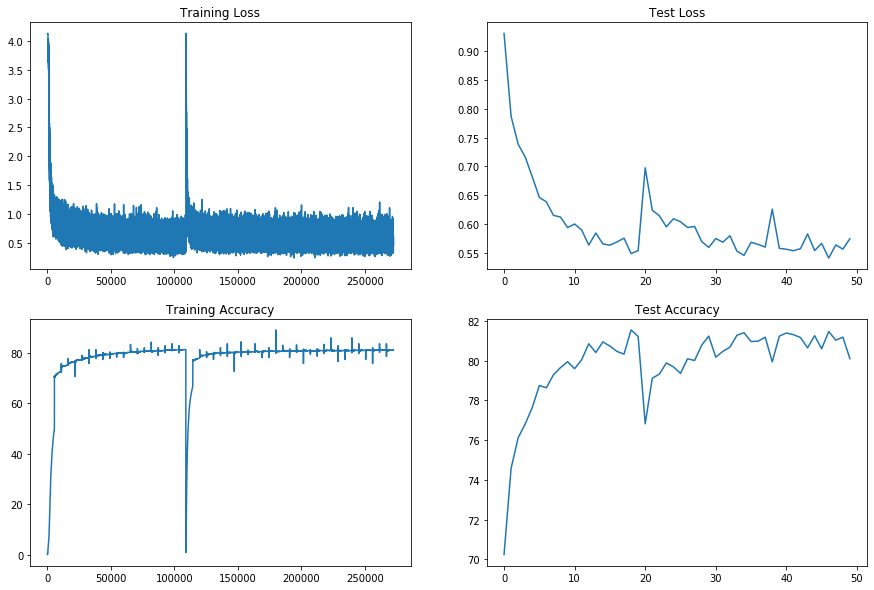

In [24]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")